# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные о странах [Country & Area Dataset](https://www.kaggle.com/datasets/lukexun/country-area-continent-region-codes)

In [3]:
# Загружаем данные
data = pd.read_csv('country_and_area_data.csv', sep=",")

In [4]:
# размер набора данных
data.shape

(250, 10)

In [5]:
# типы колонок
data.dtypes

country _or_area                        object
iso_alpha3 _code                        object
m49_code                                 int64
region_1                                object
region_2                                object
continent                               object
population_rank                        float64
population                             float64
population_percentage_ of_the_world    float64
date                                    object
dtype: object

In [6]:
# проверим есть ли пропущенные значения
data.isnull().sum()

country _or_area                        0
iso_alpha3 _code                        1
m49_code                                0
region_1                                0
region_2                                7
continent                               0
population_rank                        60
population                             21
population_percentage_ of_the_world    23
date                                   22
dtype: int64

In [7]:
# Первые 5 строк датасета
data.head()

,country _or_area,iso_alpha3 _code,m49_code,region_1,region_2,continent,population_rank,population,population_percentage_ of_the_world,date
0,Afghanistan,AFG,4,Southern Asia,None,Asia,43.0,32890171.0,0.004140,1/07/2020
1,Åland Islands,ALA,248,Northern Europe,None,Europe,NaN,30344.0,0.000004,31/12/2021
2,Albania,ALB,8,Southern Europe,None,Europe,135.0,2829741.0,0.000356,1/01/2021
3,Algeria,DZA,12,Northern Africa,None,Africa,32.0,45400000.0,0.005710,1/01/2022
4,American Samoa,ASM,16,Polynesia,None,Oceania,NaN,49710.0,0.000006,1/04/2020


In [8]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 250


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [9]:
# Удаление колонок, содержащих пустые значения
data_with_drop_null_columns = data.dropna(axis=1, how='any')
(data.shape, data_with_drop_null_columns.shape)

((250, 10), (250, 4))

In [10]:
# Удаление строк, содержащих пустые значения
data_with_drop_null_rows = data.dropna(axis=0, how='any')
(data.shape, data_with_drop_null_rows.shape)

((250, 10), (185, 10))

In [11]:
data.head()

,country _or_area,iso_alpha3 _code,m49_code,region_1,region_2,continent,population_rank,population,population_percentage_ of_the_world,date
0,Afghanistan,AFG,4,Southern Asia,None,Asia,43.0,32890171.0,0.004140,1/07/2020
1,Åland Islands,ALA,248,Northern Europe,None,Europe,NaN,30344.0,0.000004,31/12/2021
2,Albania,ALB,8,Southern Europe,None,Europe,135.0,2829741.0,0.000356,1/01/2021
3,Algeria,DZA,12,Northern Africa,None,Africa,32.0,45400000.0,0.005710,1/01/2022
4,American Samoa,ASM,16,Polynesia,None,Oceania,NaN,49710.0,0.000006,1/04/2020


In [12]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_with_set_null_values_as_zero = data.fillna(0)
data_with_set_null_values_as_zero.head()

,country _or_area,iso_alpha3 _code,m49_code,region_1,region_2,continent,population_rank,population,population_percentage_ of_the_world,date
0,Afghanistan,AFG,4,Southern Asia,None,Asia,43.0,32890171.0,0.004140,1/07/2020
1,Åland Islands,ALA,248,Northern Europe,None,Europe,0.0,30344.0,0.000004,31/12/2021
2,Albania,ALB,8,Southern Europe,None,Europe,135.0,2829741.0,0.000356,1/01/2021
3,Algeria,DZA,12,Northern Africa,None,Africa,32.0,45400000.0,0.005710,1/01/2022
4,American Samoa,ASM,16,Polynesia,None,Oceania,0.0,49710.0,0.000006,1/04/2020


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [13]:
data_with_null_column = data[data.isnull().sum()[data.isnull().sum()!=0].index]
data_with_null_column

,iso_alpha3 _code,region_2,population_rank,population,population_percentage_ of_the_world,date
0,AFG,None,43.0,32890171.0,0.004140,1/07/2020
1,ALA,None,NaN,30344.0,0.000004,31/12/2021
2,ALB,None,135.0,2829741.0,0.000356,1/01/2021
3,DZA,None,32.0,45400000.0,0.005710,1/01/2022
4,ASM,None,NaN,49710.0,0.000006,1/04/2020
...,...,...,...,...,...,...
245,ESH,None,NaN,612000.0,0.000077,1/07/2021
246,YEM,None,48.0,30491000.0,0.003830,1/07/2021
247,ZMB,Sub-Saharan Africa,64.0,18400556.0,0.002310,1/07/2021
248,ZWE,Sub-Saharan Africa,72.0,15790716.0,0.001990,1/07/2021


In [14]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
data_with_null_column = data[data.isnull().sum()[data.isnull().sum()!=0].index]
num_cols = []
#Выбираем только числовые столбцы
for col in data_with_null_column.columns:
    # Количество пустых значений 
    dt = str(data_with_null_column[col].dtype)
    if (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((data[col].isnull().sum() / data[col].count()) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, data[col].isnull().sum() , temp_perc))

Колонка population_rank. Тип данных float64. Количество пустых значений 60, 31.58%.
Колонка population. Тип данных float64. Количество пустых значений 21, 9.17%.
Колонка population_percentage_ of_the_world. Тип данных float64. Количество пустых значений 23, 10.13%.


In [15]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,population_rank,population,population_percentage_ of_the_world
0,43.0,32890171.0,0.004140
1,NaN,30344.0,0.000004
2,135.0,2829741.0,0.000356
3,32.0,45400000.0,0.005710
4,NaN,49710.0,0.000006
...,...,...,...
245,NaN,612000.0,0.000077
246,48.0,30491000.0,0.003830
247,64.0,18400556.0,0.002310
248,72.0,15790716.0,0.001990


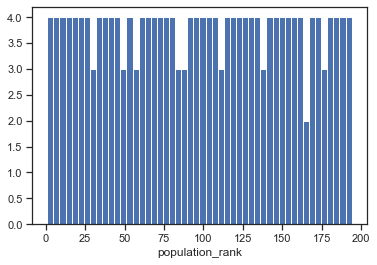

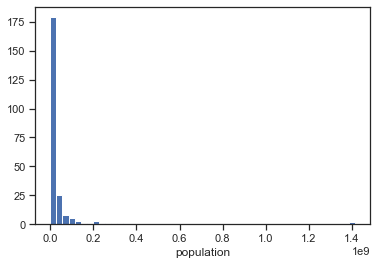

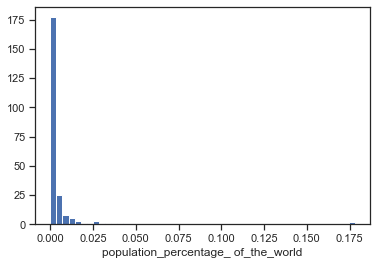

In [16]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [17]:
data_num_population = data_num[['population']]
data_num_population.head()

,population
0,32890171.0
1,30344.0
2,2829741.0
3,45400000.0
4,49710.0


In [18]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [19]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_population)
mask_missing_values_only

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [20]:
strategies=['mean', 'median', 'most_frequent']

In [21]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_population)
    return data_num_imp[mask_missing_values_only]

In [22]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([33971287.267869, 33971287.267869, 33971287.267869, 33971287.267869,
        33971287.267869, 33971287.267869, 33971287.267869, 33971287.267869,
        33971287.267869, 33971287.267869, 33971287.267869, 33971287.267869,
        33971287.267869, 33971287.267869, 33971287.267869, 33971287.267869,
        33971287.267869, 33971287.267869, 33971287.267869, 33971287.267869,
        33971287.267869]))

In [23]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([5550066., 5550066., 5550066., 5550066., 5550066., 5550066.,
        5550066., 5550066., 5550066., 5550066., 5550066., 5550066.,
        5550066., 5550066., 5550066., 5550066., 5550066., 5550066.,
        5550066., 5550066., 5550066.]))

In [24]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
        30., 30., 30., 30., 30., 30., 30., 30.]))

In [25]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [26]:
data[['population_percentage_ of_the_world']].describe()

,population_percentage_ of_the_world
count,227.000000
mean,0.004309
std,0.017309
min,0.000000
25%,0.000052
50%,0.000708
75%,0.002745
max,0.178000


In [27]:
test_num_impute_col(data, 'population_percentage_ of_the_world', strategies[0])

('population_percentage_ of_the_world',
 'mean',
 23,
 0.004309447577092511,
 0.004309447577092511)

In [28]:
test_num_impute_col(data, 'population_percentage_ of_the_world', strategies[1])

('population_percentage_ of_the_world', 'median', 23, 0.000708, 0.000708)

In [29]:
test_num_impute_col(data, 'population_percentage_ of_the_world', strategies[2])

('population_percentage_ of_the_world', 'most_frequent', 23, 0.0, 0.0)

### Обработка пропусков в категориальных данных

In [30]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка iso_alpha3 _code. Тип данных object. Количество пустых значений 1, 0.4%.
Колонка region_2. Тип данных object. Количество пустых значений 7, 2.8%.
Колонка date. Тип данных object. Количество пустых значений 22, 8.8%.


Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [31]:
cat_temp_data = data[['region_2']]
cat_temp_data.head()

,region_2
0,None
1,None
2,None
3,None
4,None


In [32]:
cat_temp_data['region_2'].unique()

array(['None', 'Sub-Saharan Africa', 'Latin America and the Caribbean',
       nan, 'Special Administrative Region of China', 'Channel Islands',
       'Province of China'], dtype=object)

In [33]:
cat_temp_data[cat_temp_data['region_2'].isnull()].shape

(7, 1)

In [34]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['None'],
       ['None'],
       ['None'],
       ['None'],
       ['None'],
       ['None'],
       ['Sub-Saharan Africa'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['Sub-Saharan Africa'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['Sub-Saharan Africa'],
       ['Latin America and the Caribbean'],
       ['Latin America and the Caribbean'],
       ['Sub-Saharan Africa'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       [

In [35]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['Channel Islands', 'Latin America and the Caribbean', 'None',
       'Province of China', 'Special Administrative Region of China',
       'Sub-Saharan Africa'], dtype=object)

In [37]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['None'],
       ['None'],
       ['None'],
       ['None'],
       ['None'],
       ['None'],
       ['Sub-Saharan Africa'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['Sub-Saharan Africa'],
       ['None'],
       ['None'],
       ['Latin America and the Caribbean'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['Sub-Saharan Africa'],
       ['Latin America and the Caribbean'],
       ['Latin America and the Caribbean'],
       ['Sub-Saharan Africa'],
       ['Latin America and the Caribbean'],
       ['None'],
       ['None'],
       [

In [78]:
np.unique(data_imp3)

array(['Channel Islands', 'Latin America and the Caribbean', 'None',
       'Province of China', 'Special Administrative Region of China',
       'Sub-Saharan Africa'], dtype=object)

In [81]:
data_imp3[data_imp3=='nan'].size

0

# Преобразование категориальных признаков в числовые

In [82]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,None
1,None
2,None
3,None
4,None
...,...
245,None
246,None
247,Sub-Saharan Africa
248,Sub-Saharan Africa


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [83]:
from sklearn.preprocessing import LabelEncoder

In [84]:
cat_enc['c1'].unique()

array(['None', 'Sub-Saharan Africa', 'Latin America and the Caribbean',
       'Special Administrative Region of China', 'Channel Islands',
       'Province of China'], dtype=object)

In [85]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [86]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['Channel Islands', 'Latin America and the Caribbean', 'None',
       'Province of China', 'Special Administrative Region of China',
       'Sub-Saharan Africa'], dtype=object)

In [87]:
cat_enc_le

array([2, 2, 2, 2, 2, 2, 5, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 5, 2, 2, 1, 1, 2, 5, 1, 1, 5, 1, 2, 2, 5, 5, 5, 2, 5, 2, 1, 5,
       5, 1, 2, 4, 4, 2, 2, 1, 5, 5, 2, 1, 5, 2, 1, 1, 2, 2, 2, 5, 2, 5,
       1, 1, 1, 2, 1, 5, 5, 2, 5, 5, 1, 2, 2, 2, 2, 1, 2, 5, 5, 5, 2, 2,
       5, 2, 2, 2, 1, 1, 2, 1, 0, 5, 5, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 0, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2,
       5, 5, 2, 2, 5, 2, 2, 1, 5, 5, 5, 1, 2, 2, 2, 2, 1, 2, 5, 2, 5, 2,
       2, 2, 2, 2, 1, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 5, 2, 2, 5, 1, 5, 1, 1, 1, 2, 1, 2, 2, 5, 0, 2, 5,
       2, 5, 5, 2, 1, 2, 2, 2, 5, 5, 1, 5, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 1, 2, 2, 2, 1, 2, 5, 2, 2, 2, 5, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 2, 5, 5, 3])

In [88]:
np.unique(cat_enc_le)

array([0, 1, 2, 3, 4, 5])

In [89]:
# В этом примере видно, что перед кодированием 
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2, 3])

array(['Channel Islands', 'Latin America and the Caribbean', 'None',
       'Province of China'], dtype=object)

### Использование OrdinalEncoder

In [90]:
from sklearn.preprocessing import OrdinalEncoder

In [95]:
data_oe = data[data.dtypes[data.dtypes=='object'].index]
data_oe.head()

,country _or_area,iso_alpha3 _code,region_1,region_2,continent,date
0,Afghanistan,AFG,Southern Asia,None,Asia,1/07/2020
1,Åland Islands,ALA,Northern Europe,None,Europe,31/12/2021
2,Albania,ALB,Southern Europe,None,Europe,1/01/2021
3,Algeria,DZA,Northern Africa,None,Africa,1/01/2022
4,American Samoa,ASM,Polynesia,None,Oceania,1/04/2020


In [96]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['Afghanistan', 'AFG', 'Southern Asia', 'None', 'Asia',
        '1/07/2020'],
       ['Åland Islands', 'ALA', 'Northern Europe', 'None', 'Europe',
        '31/12/2021'],
       ['Albania', 'ALB', 'Southern Europe', 'None', 'Europe',
        '1/01/2021'],
       ...,
       ['Zambia', 'ZMB', 'Eastern Africa', 'Sub-Saharan Africa',
        'Africa', '1/07/2021'],
       ['Zimbabwe', 'ZWE', 'Eastern Africa', 'Sub-Saharan Africa',
        'Africa', '1/07/2021'],
       ['Taiwan', 'TWN', 'Eastern Asia', 'Province of China', 'Asia',
        '31/12/2021']], dtype=object)

In [97]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[  0.,   1.,  18.,   3.,   2.,  10.],
       [249.,   4.,  13.,   3.,   3.,  38.],
       [  1.,   5.,  19.,   3.,   3.,   1.],
       ...,
       [247., 248.,   5.,   6.,   0.,  11.],
       [248., 249.,   5.,   6.,   0.,  11.],
       [218., 229.,   6.,   4.,   2.,  38.]])

In [98]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [99]:
# Уникальные значения 2 признака
np.unique(cat_enc_oe[:, 1])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [100]:
# Уникальные значения 3 признака
np.unique(cat_enc_oe[:, 2])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [101]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
        'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda',
        'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
        'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados',
        'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
        'Bolivia', 'Bonaire, Sint Eustatius and Saba',
        'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil',
        'British Indian Ocean Territory', 'British Virgin Islands',
        'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
        'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
        'Central African Republic', 'Chad', 'Chile', 'China',
        'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia',
        'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia',
        'Cuba', 'Curaçao', 'Cyprus', 'Czechia', 'Côte d’Ivoire',
        'Democratic Republic of the Congo', 'Denmark'

In [102]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['Afghanistan', 'AFG', 'Southern Asia', 'None', 'Asia',
        '1/07/2020'],
       ['Åland Islands', 'ALA', 'Northern Europe', 'None', 'Europe',
        '31/12/2021'],
       ['Albania', 'ALB', 'Southern Europe', 'None', 'Europe',
        '1/01/2021'],
       ...,
       ['Zambia', 'ZMB', 'Eastern Africa', 'Sub-Saharan Africa',
        'Africa', '1/07/2021'],
       ['Zimbabwe', 'ZWE', 'Eastern Africa', 'Sub-Saharan Africa',
        'Africa', '1/07/2021'],
       ['Taiwan', 'TWN', 'Eastern Asia', 'Province of China', 'Asia',
        '31/12/2021']], dtype=object)

### Кодирование шкал порядка

Библиотека scikit-learn не предоставляет готового решения для кодирования шкал порядка, но можно воспользоваться [функцией map для отдельных объектов Series.](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [103]:
# пример шкалы порядка 'small' < 'medium' < 'large'
sizes = ['small', 'medium', 'large', 'small', 'medium', 'large', 'small', 'medium', 'large']

In [104]:
pd_sizes = pd.DataFrame(data={'sizes':sizes})
pd_sizes

,sizes
0,small
1,medium
2,large
3,small
4,medium
5,large
6,small
7,medium
8,large


In [105]:
pd_sizes['sizes_codes'] = pd_sizes['sizes'].map({'small':1, 'medium':2, 'large':3})
pd_sizes

,sizes,sizes_codes
0,small,1
1,medium,2
2,large,3
3,small,1
4,medium,2
5,large,3
6,small,1
7,medium,2
8,large,3


In [106]:
pd_sizes['sizes_decoded'] = pd_sizes['sizes_codes'].map({1:'small', 2:'medium', 3:'large'})
pd_sizes

,sizes,sizes_codes,sizes_decoded
0,small,1,small
1,medium,2,medium
2,large,3,large
3,small,1,small
4,medium,2,medium
5,large,3,large
6,small,1,small
7,medium,2,medium
8,large,3,large


## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [107]:
from sklearn.preprocessing import OneHotEncoder

In [108]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [109]:
cat_enc.shape

(250, 1)

In [110]:
cat_enc_ohe.shape

(250, 6)

In [111]:
cat_enc_ohe

<250x6 sparse matrix of type '<class 'numpy.float64'>'
	with 250 stored elements in Compressed Sparse Row format>

In [112]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])

In [113]:
cat_enc.head(10)

,c1
0,None
1,None
2,None
3,None
4,None
5,None
6,Sub-Saharan Africa
7,Latin America and the Caribbean
8,None
9,Latin America and the Caribbean


## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [115]:
pd.get_dummies(cat_enc).head()

,c1_Channel Islands,c1_Latin America and the Caribbean,c1_None,c1_Province of China,c1_Special Administrative Region of China,c1_Sub-Saharan Africa
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [116]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,region_2_Channel Islands,region_2_Latin America and the Caribbean,region_2_None,region_2_Province of China,region_2_Special Administrative Region of China,region_2_Sub-Saharan Africa,region_2_nan
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [117]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [118]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['population']])

D:\anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


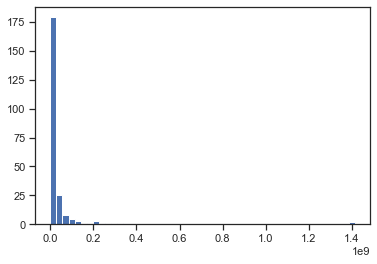

In [119]:
plt.hist(data['population'], 50)
plt.show()

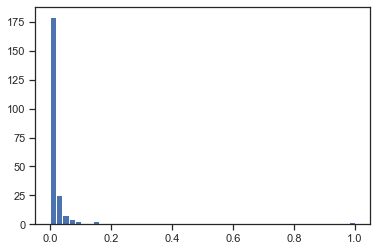

In [120]:
plt.hist(sc1_data, 50)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [121]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['population']])

D:\anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


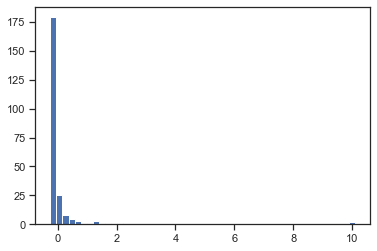

In [122]:
plt.hist(sc2_data, 50)
plt.show()